In [ ]:
# default_exp data

In [ ]:
%load_ext autotime

# Data preparation

> Dieses Modul werden die Daten runtergeladen und für die Verarbeitung vorbereitet.

In [ ]:
!pip install xgboost

In [ ]:
#hide
from nbdev.showdoc import *

## Download und unzip Data

In [ ]:
#export
import os
import csv
import gdown
import pandas as pd
import numpy as np
import time
from nbdev import export
from pathlib import Path
from zipfile import ZipFile

from tqdm import tqdm

/home/wilhelm/miniconda3/envs/CommunityLearning/lib/python3.7/site-packages/fastprogress/fastprogress.py:102: UserWarning: Couldn't import ipywidgets properly, progress bar will use console behavior
  warn("Couldn't import ipywidgets properly, progress bar will use console behavior")


In [ ]:
#export 
def download_santander_data():
    """downloads the data from gdrive to the data folder"""   
    dest = Path('data/raw/train_ver2.csv.zip')
    
    #only download if file not already exists
    if not dest.exists(): 
        dest.parent.mkdir(parents=True, exist_ok=True)
        
        gdown.download(
            'https://drive.google.com/uc?export=download&id=1H-dFcuqI99OkXAawsTMkmylBz3exNUgZ', 
            'data/raw/train_ver2.csv.zip',
            quiet=False)
    else:
        print(f"file {dest} already exists.")
        
    return dest

In [ ]:
path_file = download_santander_data()

In [ ]:
#export 
def unzip(path:[Path,str], dest:[Path,str]='.'):
    """unzips a given file"""
    path = Path(path)
    dest = path.parent / path.stem
    
    if not dest.exists():
        with ZipFile(str(path), 'r') as zipObj:
            zipObj.extractall(str(path.parent))
            print(f'extracted to {path.parent / path.stem}')
    else:
        print(f"file {dest} already exists!")
    
    return dest

In [ ]:
#export
def timeit(method):
    """timeit decorator to measure execution times"""
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [ ]:
path_file = unzip(path_file, path_file.parent)

## clean data
Hierfür verwenden wir im Wesentlichen die Empfehlungen von [Alan Pryors Jupyter Notebook](https://www.kaggle.com/apryor6/detailed-cleaning-visualization-python). 

In [ ]:
#export 
def load_csv(path_file:[Path, str]='data/raw/train_ver2.csv'):
    """load csv data and convert """
    x_vars_list = []
    y_vars_list = []
    path_file = Path(path_file)
    for row in csv.DictReader(path_file):
        cust_id = int(row['ncodpers']) # kundennummer

In [ ]:
import time
for _ in tqdm(range(100)):
    time.sleep(0.1)

100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


In [ ]:
path_file = Path('data/raw/train_ver2.csv')
num_lines = sum(1 for line in open(path_file))
rows = []
x = 0
for row in tqdm(csv.DictReader(open(path_file)), total=num_lines):
    x += 1
    rows.append(row)

x
    

 34%|███▍      | 4685925/13647310 [01:15<01:54, 78196.70it/s]

In [ ]:
#export
class SantanderData:
    """class which handles the data in a pipline style"""
    
    
    mapping_dict = {
'ind_empleado'  : {-99:0, 'N':1, 'B':2, 'F':3, 'A':4, 'S':5},
'sexo'          : {'V':0, 'H':1, -99:2},
'ind_nuevo'     : {'0':0, '1':1, -99:2},
'indrel'        : {'1':0, '99':1, -99:2},
'indrel_1mes'   : {-99:0, '1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':5},
'tiprel_1mes'   : {-99:0, 'I':1, 'A':2, 'P':3, 'R':4, 'N':5},
'indresi'       : {-99:0, 'S':1, 'N':2},
'indext'        : {-99:0, 'S':1, 'N':2},
'conyuemp'      : {-99:0, 'S':1, 'N':2},
'indfall'       : {-99:0, 'S':1, 'N':2},
'tipodom'       : {-99:0, '1':1},
'ind_actividad_cliente' : {'0':0, '1':1, -99:2},
'segmento'      : {'02 - PARTICULARES':0, '03 - UNIVERSITARIO':1, '01 - TOP':2, -99:2},
'pais_residencia' : {'LV': 102, 'BE': 12, 'BG': 50, 'BA': 61, 'BM': 117, 'BO': 62, 'JP': 82, 'JM': 116, 'BR': 17, 'BY': 64, 'BZ': 113, 'RU': 43, 'RS': 89, 'RO': 41, 'GW': 99, 'GT': 44, 'GR': 39, 'GQ': 73, 'GE': 78, 'GB': 9, 'GA': 45, 'GN': 98, 'GM': 110, 'GI': 96, 'GH': 88, 'OM': 100, 'HR': 67, 'HU': 106, 'HK': 34, 'HN': 22, 'AD': 35, 'PR': 40, 'PT': 26, 'PY': 51, 'PA': 60, 'PE': 20, 'PK': 84, 'PH': 91, 'PL': 30, 'EE': 52, 'EG': 74, 'ZA': 75, 'EC': 19, 'AL': 25, 'VN': 90, 'ET': 54, 'ZW': 114, 'ES': 0, 'MD': 68, 'UY': 77, 'MM': 94, 'ML': 104, 'US': 15, 'MT': 118, 'MR': 48, 'UA': 49, 'MX': 16, 'IL': 42, 'FR': 8, 'MA': 38, 'FI': 23, 'NI': 33, 'NL': 7, 'NO': 46, 'NG': 83, 'NZ': 93, 'CI': 57, 'CH': 3, 'CO': 21, 'CN': 28, 'CM': 55, 'CL': 4, 'CA': 2, 'CG': 101, 'CF': 109, 'CD': 112, 'CZ': 36, 'CR': 32, 'CU': 72, 'KE': 65, 'KH': 95, 'SV': 53, 'SK': 69, 'KR': 87, 'KW': 92, 'SN': 47, 'SL': 97, 'KZ': 111, 'SA': 56, 'SG': 66, 'SE': 24, 'DO': 11, 'DJ': 115, 'DK': 76, 'DE': 10, 'DZ': 80, 'MK': 105, -99: 1, 'LB': 81, 'TW': 29, 'TR': 70, 'TN': 85, 'LT': 103, 'LU': 59, 'TH': 79, 'TG': 86, 'LY': 108, 'AE': 37, 'VE': 14, 'IS': 107, 'IT': 18, 'AO': 71, 'AR': 13, 'AU': 63, 'AT': 6, 'IN': 31, 'IE': 5, 'QA': 58, 'MZ': 27},
'canal_entrada' : {'013': 49, 'KHP': 160, 'KHQ': 157, 'KHR': 161, 'KHS': 162, 'KHK': 10, 'KHL': 0, 'KHM': 12, 'KHN': 21, 'KHO': 13, 'KHA': 22, 'KHC': 9, 'KHD': 2, 'KHE': 1, 'KHF': 19, '025': 159, 'KAC': 57, 'KAB': 28, 'KAA': 39, 'KAG': 26, 'KAF': 23, 'KAE': 30, 'KAD': 16, 'KAK': 51, 'KAJ': 41, 'KAI': 35, 'KAH': 31, 'KAO': 94, 'KAN': 110, 'KAM': 107, 'KAL': 74, 'KAS': 70, 'KAR': 32, 'KAQ': 37, 'KAP': 46, 'KAW': 76, 'KAV': 139, 'KAU': 142, 'KAT': 5, 'KAZ': 7, 'KAY': 54, 'KBJ': 133, 'KBH': 90, 'KBN': 122, 'KBO': 64, 'KBL': 88, 'KBM': 135, 'KBB': 131, 'KBF': 102, 'KBG': 17, 'KBD': 109, 'KBE': 119, 'KBZ': 67, 'KBX': 116, 'KBY': 111, 'KBR': 101, 'KBS': 118, 'KBP': 121, 'KBQ': 62, 'KBV': 100, 'KBW': 114, 'KBU': 55, 'KCE': 86, 'KCD': 85, 'KCG': 59, 'KCF': 105, 'KCA': 73, 'KCC': 29, 'KCB': 78, 'KCM': 82, 'KCL': 53, 'KCO': 104, 'KCN': 81, 'KCI': 65, 'KCH': 84, 'KCK': 52, 'KCJ': 156, 'KCU': 115, 'KCT': 112, 'KCV': 106, 'KCQ': 154, 'KCP': 129, 'KCS': 77, 'KCR': 153, 'KCX': 120, 'RED': 8, 'KDL': 158, 'KDM': 130, 'KDN': 151, 'KDO': 60, 'KDH': 14, 'KDI': 150, 'KDD': 113, 'KDE': 47, 'KDF': 127, 'KDG': 126, 'KDA': 63, 'KDB': 117, 'KDC': 75, 'KDX': 69, 'KDY': 61, 'KDZ': 99, 'KDT': 58, 'KDU': 79, 'KDV': 91, 'KDW': 132, 'KDP': 103, 'KDQ': 80, 'KDR': 56, 'KDS': 124, 'K00': 50, 'KEO': 96, 'KEN': 137, 'KEM': 155, 'KEL': 125, 'KEK': 145, 'KEJ': 95, 'KEI': 97, 'KEH': 15, 'KEG': 136, 'KEF': 128, 'KEE': 152, 'KED': 143, 'KEC': 66, 'KEB': 123, 'KEA': 89, 'KEZ': 108, 'KEY': 93, 'KEW': 98, 'KEV': 87, 'KEU': 72, 'KES': 68, 'KEQ': 138, -99: 6, 'KFV': 48, 'KFT': 92, 'KFU': 36, 'KFR': 144, 'KFS': 38, 'KFP': 40, 'KFF': 45, 'KFG': 27, 'KFD': 25, 'KFE': 148, 'KFB': 146, 'KFC': 4, 'KFA': 3, 'KFN': 42, 'KFL': 34, 'KFM': 141, 'KFJ': 33, 'KFK': 20, 'KFH': 140, 'KFI': 134, '007': 71, '004': 83, 'KGU': 149, 'KGW': 147, 'KGV': 43, 'KGY': 44, 'KGX': 24, 'KGC': 18, 'KGN': 11}
}
    
    @timeit
    def load_csv(self, path_file:[Path, str], limit_rows=None):
        """load csv file to a pandas df"""
        x_vars_list = []
        y_vars_list = []
        path_file = Path(path_file)
        for row in csv.DictReader(path_file):
            cust_id = int(row['ncodpers']) # kundennummer
            x_vars
            
        
        return self
    
    @timeit
    def convert_dates(self):
        """converting the dates of the df"""
        self.df["fecha_dato"] = pd.to_datetime(self.df["fecha_dato"],format="%Y-%m-%d")
        self.df["fecha_alta"] = pd.to_datetime(self.df["fecha_alta"],format="%Y-%m-%d")
        return self
    
    @timeit
    def add_month_feature(self):
        """add buy month to the features"""
        self.df["month"] = pd.DatetimeIndex(self.df["fecha_dato"]).month
        return self
    
    @timeit
    def add_age_feature(self):
        """add customer age feature"""
        self.df["age"]   = pd.to_numeric(self.df["age"], errors="coerce")
        return self
    
    @timeit
    def clean_age(self):
        """clean age with NA small and big ages"""
        self.df.loc[self.df.age < 18,"age"]  = (self.df.loc[(self.df.age >= 18) 
                                                       & (self.df.age <= 30),"age"].mean(skipna=True))
        self.df.loc[self.df.age > 100,"age"] = (self.df.loc[(self.df.age >= 30) 
                                                       & (self.df.age <= 100),"age"].mean(skipna=True))
        self.df["age"].fillna(self.df["age"].mean(),inplace=True)
        self.df["age"] = self.df["age"].astype(int)
        return self
    
    
    @timeit
    def clean_ind_nuevo(self):
        """ind_nuevo indicates a new customer. We replace missing values with one"""
        self.df.loc[self.df["ind_nuevo"].isnull(),"ind_nuevo"] = 1
        return self
    
    
    @timeit
    def clean_antiguedad(self):
        """antiguedad means senority. All missing antiguedad have the same NAs as the ind_nuevo."""
        self.df.antiguedad = pd.to_numeric(self.df.antiguedad,errors="coerce")
        self.df.loc[self.df.antiguedad.isnull(),"antiguedad"] = self.df.antiguedad.min()
        self.df.loc[self.df.antiguedad < 0.0, "antiguedad"]  = 0 # Thanks @StephenSmith for bug-find
        return self
    
    
    @timeit
    def replace_missing_dates_with_median(self):
        """replace missing fecha_alta with median dates"""
        dates=self.df.loc[:,"fecha_alta"].sort_values().reset_index()
        median_date = int(np.median(dates.index.values))
        self.df.loc[self.df.fecha_alta.isnull(),"fecha_alta"] = dates.loc[median_date,"fecha_alta"]
        return self
    
    
    @timeit
    def clean_indrel(self):
        """
        indrel value of 1 indicates primary customer 99 means primary customer at the beginning 
        of the month but not end of the month"""
        self.df.loc[self.df.indrel.isnull(),"indrel"] = 1
        return self
    
    
    @timeit
    def drop_tipodom(self):
        """drop tipodom - adress type"""
        self.df.drop("tipodom",axis=1,inplace=True)
        return self
    
    
    @timeit
    def drop_codprov(self):
        """drop codprov - province code"""
        self.df.drop("cod_prov",axis=1,inplace=True)
        return self
    
    
    @timeit
    def clean_ind_actividad_cliente(self):
        """we replace NANs with the median"""
        self.df.loc[self.df.ind_actividad_cliente.isnull(),"ind_actividad_cliente"] = \
        self.df["ind_actividad_cliente"].median()
        return self
    
    
    @timeit
    def clean_nomprov(self):
        """remove special character and NANs"""
        self.df.loc[self.df.nomprov=="CORU\xc3\x91A, A","nomprov"] = "CORUNA, A"
        self.df.loc[self.df.nomprov.isnull(),"nomprov"] = "UNKNOWN"
        return self
    
    @timeit
    def clean_renta(self):
        """fill in NaNs with median value from its region"""
        grouped = self.df.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()
        new_incomes = pd.merge(self.df,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
        new_incomes = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("nomprov")
        self.df.sort_values("nomprov",inplace=True)
        self.df = self.df.reset_index()
        new_incomes = new_incomes.reset_index()
        
        self.df.loc[self.df.renta.isnull(),"renta"] = new_incomes.loc[self.df.renta.isnull(),"renta"].reset_index()
        self.df.loc[self.df.renta.isnull(),"renta"] = self.df.loc[self.df.renta.notnull(),"renta"].median()
        self.df.sort_values(by="fecha_dato",inplace=True)
        return self
    
    
    @timeit
    def clean_ind_nomina_ult1(self):
        """clean ind_nomina_ult1 (payroll)"""        
        self.df.loc[self.df.ind_nomina_ult1.isnull(), "ind_nomina_ult1"] = 0
        return self

    
    @timeit
    def clean_ind_pens_ult1(self):
        """clean ind_nomina_ult1 (pension)"""        
        self.df.loc[self.df.ind_nom_pens_ult1.isnull(), "ind_nom_pens_ult1"] = 0
        return self
    
    
    @timeit
    def clean_character_cols(self):
        """clean character columns, if NA fill with most common value"""        
        string_data = self.df.select_dtypes(include=["object"])
        missing_columns = [col for col in string_data if string_data[col].isnull().any()]
        
        self.df.loc[self.df.indfall.isnull(),"indfall"] = "N"
        self.df.loc[self.df.tiprel_1mes.isnull(),"tiprel_1mes"] = "A"
        self.df.tiprel_1mes = self.df.tiprel_1mes.astype("category")

        # As suggested by @StephenSmith
        map_dict = { 1.0  : "1",
                    "1.0" : "1",
                    "1"   : "1",
                    "3.0" : "3",
                    "P"   : "P",
                    3.0   : "3",
                    2.0   : "2",
                    "3"   : "3",
                    "2.0" : "2",
                    "4.0" : "4",
                    "4"   : "4",
                    "2"   : "2"}

        self.df.indrel_1mes.fillna("P",inplace=True)
        self.df.indrel_1mes = self.df.indrel_1mes.apply(lambda x: map_dict.get(x,x))
        self.df.indrel_1mes = self.df.indrel_1mes.astype("category")


        unknown_cols = [col for col in missing_columns if col not in ["indfall","tiprel_1mes","indrel_1mes"]]
        for col in unknown_cols:
            self.df.loc[self.df[col].isnull(),col] = "UNKNOWN"
        
        return self

    
    @timeit
    def add_region(self, lookup:dict):
        """adds a region column for south and north"""
        self.df['region'] = self.df.apply(lambda row: region[row.nomprov], axis=1)
        return self
    
    
    @timeit
    def save_data(self, path:[str, Path]='data/interim/data.pkl'):
        """saves the data as a pickle file"""        
        path = Path(path)
        path.parent.mkdir(parents=True, exist_ok=True)
        self.df.to_pickle(str(path))
        return self
    
    @timeit
    def load_data(self, path:[str, Path]='data/interim/data.pkl'):
        """saves the data as a pickle file"""        
        path = Path(path)        
        self.df = pd.read_pickle(str(path))
        return self
        
        
               

        

In [ ]:
if os.path.exists('data/interim/data.pkl'):
    data = SantanderData().load_data()
else:
    data = (SandanderData()
            .load_csv(path_file, 50000)
            .save_data()
            #.load_csv(path_file, 10000)
            .convert_dates()
            .add_month_feature()
            .add_age_feature()
            .clean_age()
            .clean_ind_nuevo()
            .clean_antiguedad()
            .replace_missing_dates_with_median()
            .clean_indrel()
            .drop_tipodom()
            .drop_codprov()
            .clean_ind_actividad_cliente()
            .clean_nomprov()
            .clean_renta()
            .clean_ind_nomina_ult1()
            .clean_ind_pens_ult1()
            .clean_character_cols()
            .save_data()
           )

In [ ]:
#slow
if os.path.exists('data/interim/data.pkl'):
    data = SantanderData().load_data()
else:
    data = (SandanderData()
            .load_csv(path_file)
            .save_data()
            #.load_csv(path_file, 10000)
            .convert_dates()
            .add_month_feature()
            .add_age_feature()
            .clean_age()
            .clean_ind_nuevo()
            .clean_antiguedad()
            .replace_missing_dates_with_median()
            .clean_indrel()
            .drop_tipodom()
            .drop_codprov()
            .clean_ind_actividad_cliente()
            .clean_nomprov()
            .clean_renta()
            .clean_ind_nomina_ult1()
            .clean_ind_pens_ult1()
            .clean_character_cols()
            .save_data()
           )

In [ ]:

assert type(data.df) == pd.core.frame.DataFrame
assert type(data) == SantanderData
assert "age" in data.df.columns
assert "month" in data.df.columns
assert data.df.fecha_dato.dtype == '<M8[ns]'
assert data.df.fecha_alta.dtype == '<M8[ns]'
assert data.df.age.isnull().any() == False, "found NAs in dataset"
assert data.df.age.min() >= 18
assert data.df.age.max() <= 100
assert data.df.age.dtype == 'int'
assert data.df.ind_nuevo.isnull().any() == False
assert data.df.antiguedad.isnull().any() == False
assert data.df.antiguedad.min() >= 0
assert data.df.fecha_alta.isnull().any() == False
assert data.df.indrel.isnull().any() == False
assert "tipodom" not in data.df.columns
assert "codprov" not in data.df.columns
assert data.df["ind_actividad_cliente"].isnull().any() == False
assert data.df['nomprov'].isnull().any() == False
assert data.df.renta.isnull().any() == False
assert data.df.ind_nomina_ult1.isnull().any() == False
assert data.df.ind_nom_pens_ult1.isnull().any() == False
assert Path('data/interim/data.pkl').exists()

## Slice Data
Nun werden wir die Daten anhand der Provinz teilen. Dabei werden wir eine Nord- Südtrennung vornhemen.
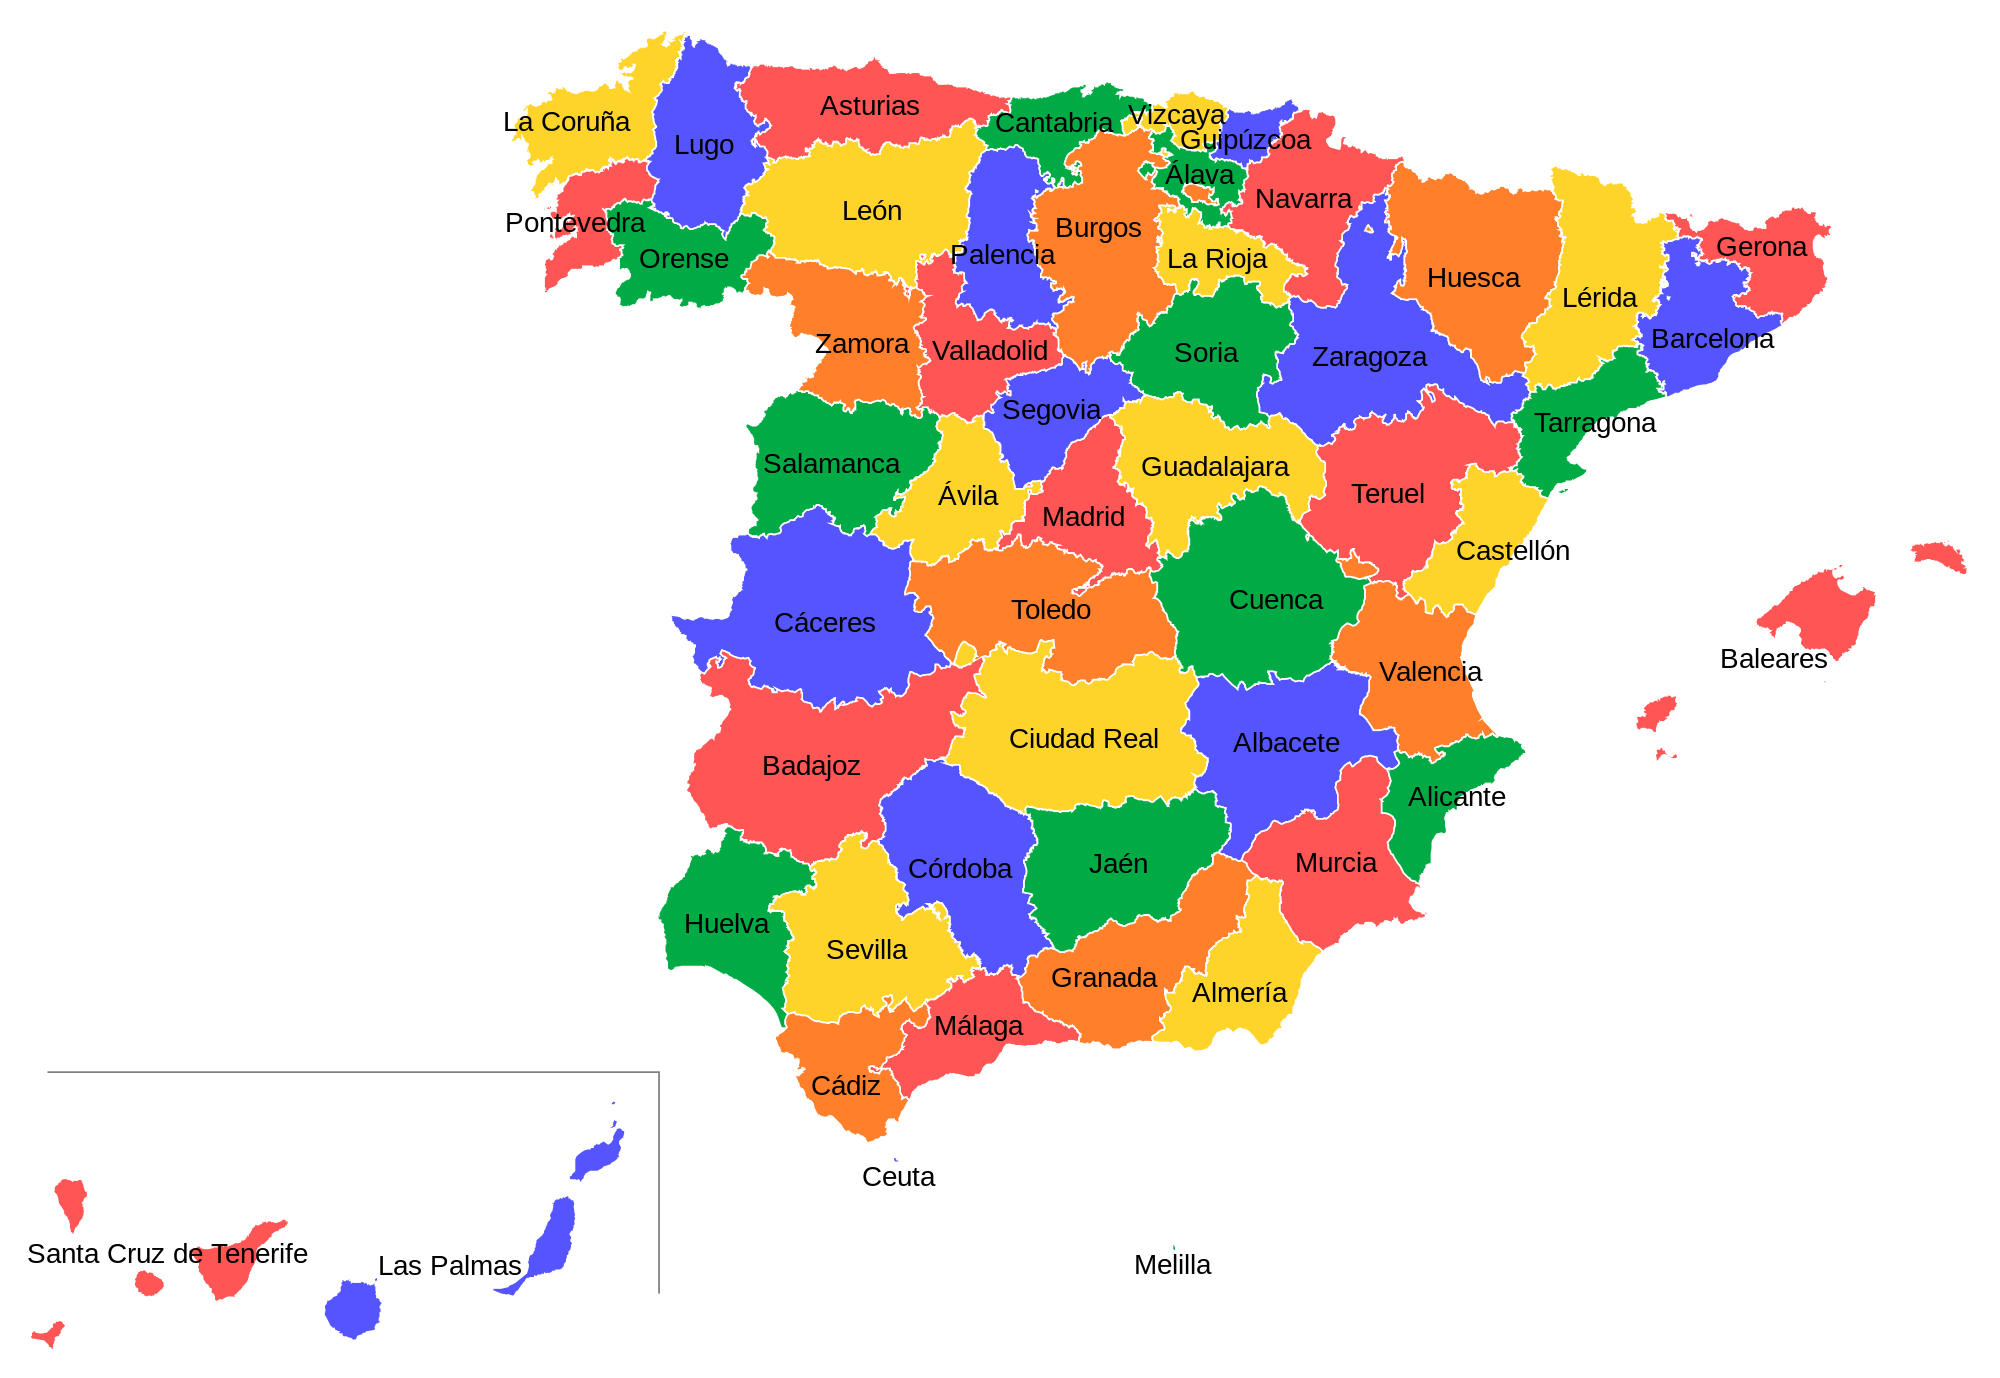

In [ ]:
#export
region = {
"ALAVA":"north",
"ALBACETE":"south",
"ALICANTE":"south",
"ALMERIA":"south",
"ASTURIAS":"north",
"AVILA":"north",
"BADAJOZ":"south",
"BALEARS, ILLES":"north",
"BARCELONA":"north",
"BIZKAIA":"north",
"BURGOS":"north",
"CACERES":"north",
"CADIZ":"south",
"CANTABRIA":"north",
"CASTELLON":"north",
"CEUTA":"south",
"CIUDAD REAL":"south",
"CORDOBA":"south",
"CORUÑA, A":"north",
"CUENCA":"north",
"GIPUZKOA":"north",
"GIRONA":"north",
"GRANADA":"south",
"GUADALAJARA":"north",
"HUELVA":"south",
"HUESCA":"north",
"JAEN":"south",
"LEON":"north",
"LERIDA":"north",
"LUGO":"north",
"MADRID":"south",
"MALAGA":"south",
"MELILLA":"south",
"MURCIA":"south",
"NAVARRA":"north",
"OURENSE":"north",
"PALENCIA":"north",
"PALMAS, LAS":"north",
"PONTEVEDRA":"north",
"RIOJA, LA":"north",
"SALAMANCA":"north",
"SANTA CRUZ DE TENERIFE":"north",
"SEGOVIA":"north",
"SEVILLA":"south",
"SORIA":"north",
"TARRAGONA":"north",
"TERUEL":"north",
"TOLEDO":"north",
"UNKNOWN":"north",
"VALENCIA":"north",
"VALLADOLID":"north",
"ZAMORA":"north",
"ZARAGOZA":"north"
}

In [ ]:
data = data.add_region(region)
data = data.save_data()

In [ ]:
region_df = data.df.groupby(by='region').size()
x =region_df.groupby(level=0).apply(lambda x: 100 * float(x) / float(len(data.df)))
x

In [ ]:
data.df.info()

## Target Labels
Das Ziel ideser 

## Export

In [ ]:
#hide
from nbdev.export import *
notebook2script()